Enrique Ulises Báez Gómez Tagle - 0241823

In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data_clean = data.dropna(subset=['nombre'])
data_transposed = data_clean.set_index('nombre').T
data_transposed.index = pd.to_datetime(data_transposed.index, errors='coerce', format='%d-%m-%Y')
data_transposed = data_transposed.dropna(how='all')

In [6]:
if not isinstance(data_transposed.index, pd.DatetimeIndex):
    data_transposed.index = pd.to_datetime(data_transposed.index, errors='coerce')

data_2020 = data_transposed[data_transposed.index.year == 2020]

In [7]:
scaler = StandardScaler()
data_2020_normalized = pd.DataFrame(scaler.fit_transform(data_2020), index=data_2020.index, columns=data_2020.columns)

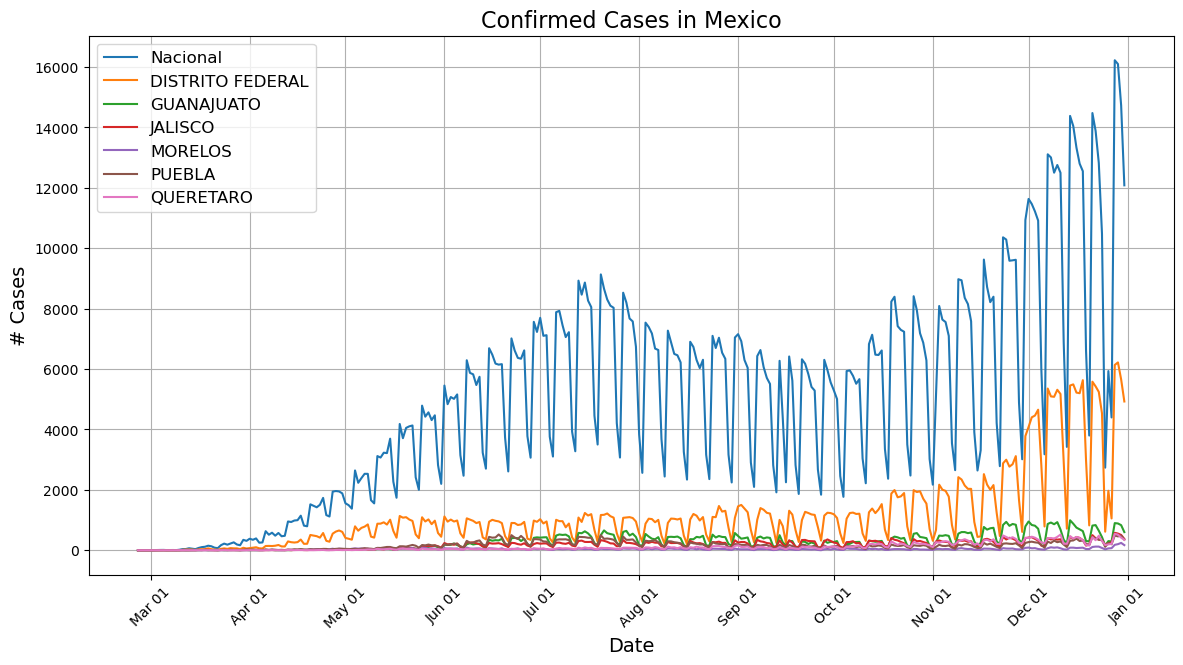

In [8]:
selected_states = ['Nacional', 'DISTRITO FEDERAL', 'GUANAJUATO', 'JALISCO', 'MORELOS', 'PUEBLA', 'QUERETARO']

plt.figure(figsize=(14, 7))

for state in selected_states:
    plt.plot(data_2020.index, data_2020[state], label=state)

plt.title('Confirmed Cases in Mexico', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('# Cases', fontsize=14)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.legend(fontsize=12)

plt.grid(True)
plt.show()

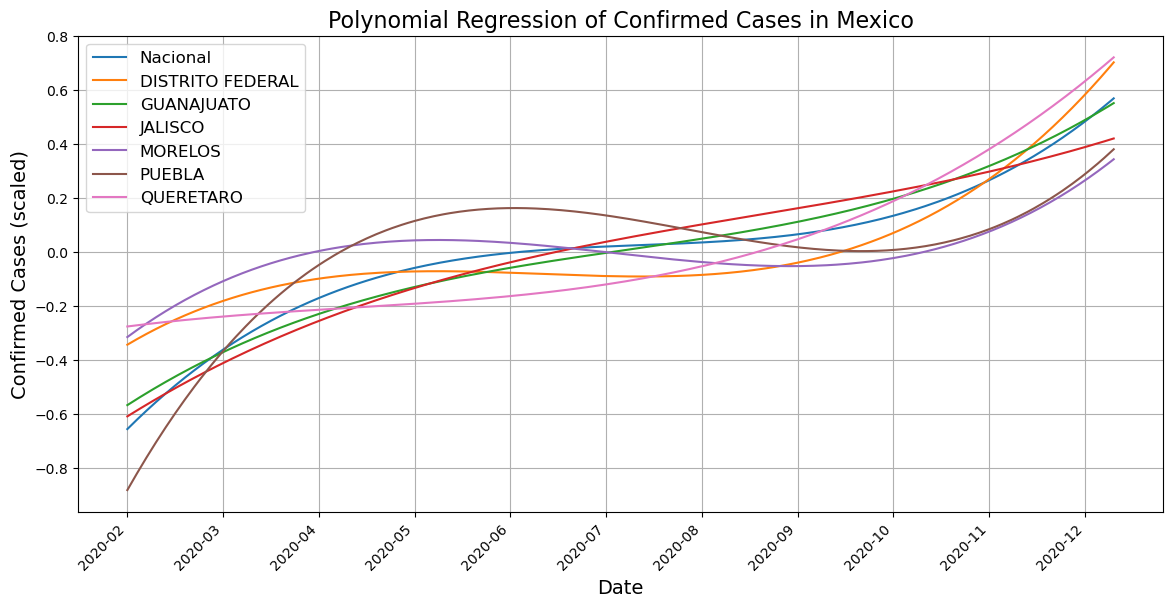

In [9]:
data_2020_scaled = data_2020_normalized / data_2020_normalized.abs().max()

df_poly = pd.DataFrame(index=data_2020_normalized.index)

plt.figure(figsize=(14, 7))

for state in selected_states:
    entity_cases = data_2020_scaled[state]
    ordinal_dates = data_2020_scaled.index.map(pd.Timestamp.toordinal)

    poly_fit = np.poly1d(np.polyfit(ordinal_dates, entity_cases.values, 3))

    df_poly[state] = poly_fit(ordinal_dates)

    plt.plot(data_2020_scaled.index, df_poly[state], label=state)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.xticks(ticks=data_2020_scaled.index[::30], labels=data_2020_scaled.index[::30].strftime('%Y-%m'), rotation=45)

plt.title('Polynomial Regression of Confirmed Cases in Mexico', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Confirmed Cases (scaled)', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)
plt.show()

In [10]:
selected_states = ['DISTRITO FEDERAL', 'GUANAJUATO', 'JALISCO', 'MORELOS', 'PUEBLA', 'QUERETARO']
df_poly2 = df_poly[selected_states]

In [11]:
scaler = StandardScaler()
df_poly2_scaled = scaler.fit_transform(df_poly2)

In [12]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(df_poly2_scaled)

In [13]:
pca_df = pd.DataFrame(data=pca_data, columns=['Comp 1', 'Comp 2', 'Comp 3'], index=df_poly2.index)

In [14]:
explained_variance = pca.explained_variance_ratio_

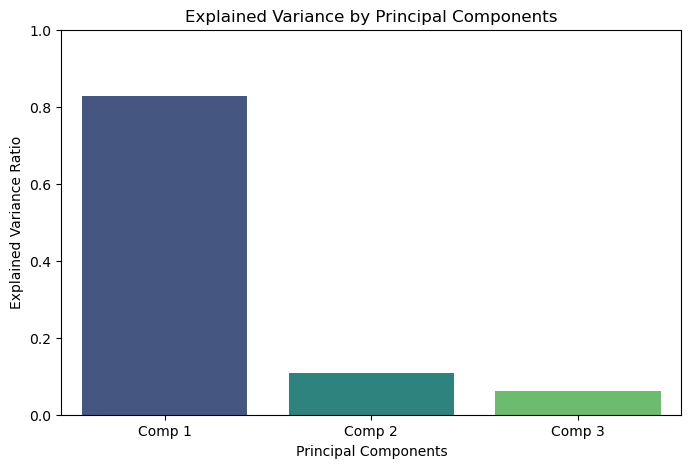

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(x=['Comp 1', 'Comp 2', 'Comp 3'], y=explained_variance, palette='viridis')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.ylim(0, 1)
plt.show()

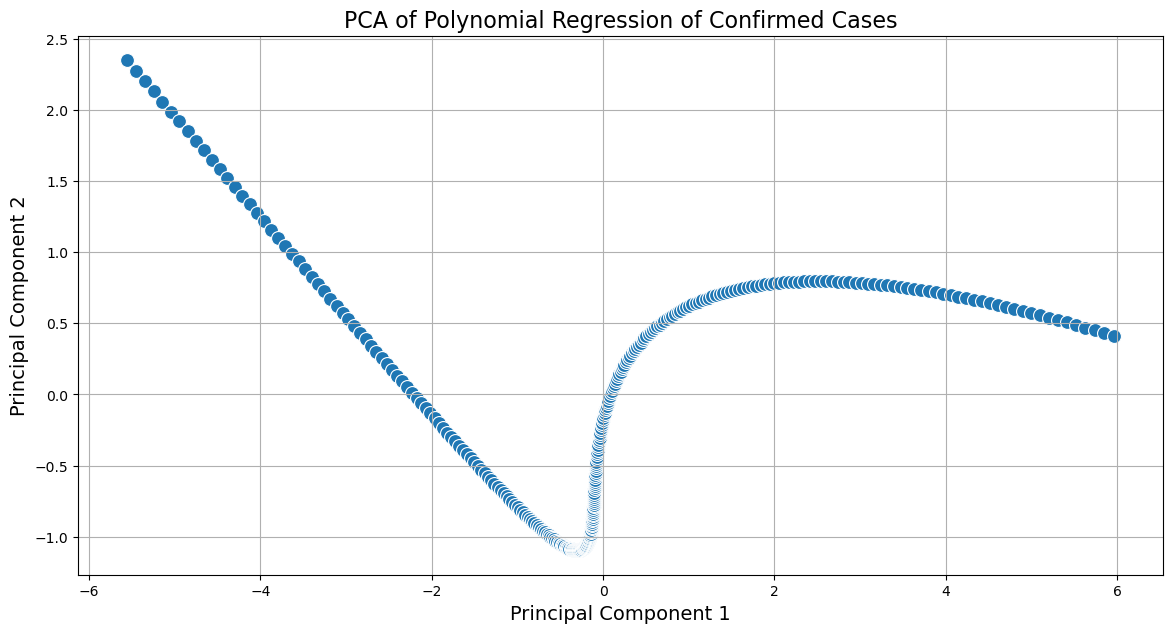

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

sns.scatterplot(data=pca_df, x='Comp 1', y='Comp 2', ax=ax, s=100)

ax.set_title('PCA of Polynomial Regression of Confirmed Cases', fontsize=16)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

plt.grid(True)
plt.show()

In [17]:
print(pca_df.head())

              Comp 1    Comp 2    Comp 3
2020-02-26 -5.553878  2.347575  0.087958
2020-02-27 -5.449376  2.273523  0.112058
2020-02-28 -5.346105  2.200284  0.135727
2020-02-29 -5.244375  2.128278  0.158627
2020-03-01 -5.143864  2.057078  0.181068


In [18]:
explained_variance_ratio = pca.explained_variance_ratio_

print('Explained Variance Ratio:')
for i, ratio in enumerate(explained_variance_ratio, 1):
    print(f'Component {i}: {ratio:.4f}')

components_df = pd.DataFrame(pca.components_, columns=df_poly2.columns, index=['Comp 1', 'Comp 2', 'Comp 3'])

print('\nPCA Components:')

import IPython.display as display
display.display(components_df)

Explained Variance Ratio:
Component 1: 0.8285
Component 2: 0.1094
Component 3: 0.0621

PCA Components:


,DISTRITO FEDERAL,GUANAJUATO,JALISCO,MORELOS,PUEBLA,QUERETARO
Comp 1,0.420622,0.437317,0.420551,0.398021,0.361518,0.407249
Comp 2,0.287857,0.118125,0.033699,-0.342480,-0.720518,0.515374
Comp 3,0.421349,-0.328415,-0.567842,0.603150,-0.159024,0.055550


In [19]:
max_component_state = components_df.idxmax(axis=1)

print('Most Contributing State for Each Component:')
for component, state in max_component_state.items():
    print(f'{component}: {state}')

Most Contributing State for Each Component:
Comp 1: GUANAJUATO
Comp 2: QUERETARO
Comp 3: MORELOS


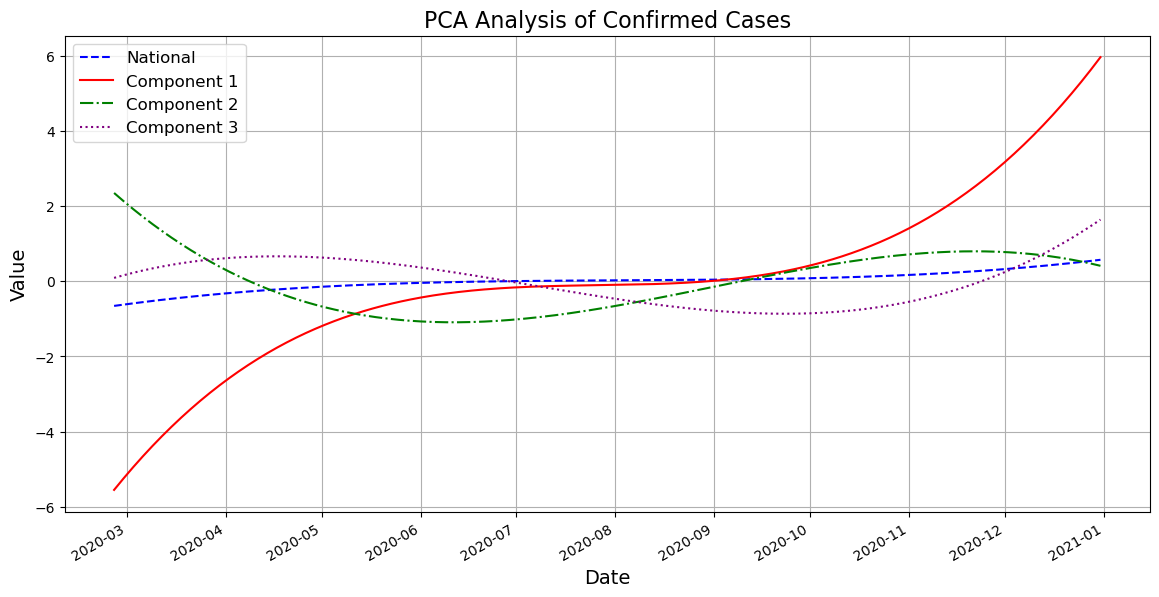

In [20]:
plt.figure(figsize=(14, 7))

plt.plot(df_poly.index, df_poly['Nacional'], label='National', linestyle='--', color='blue')

plt.plot(pca_df.index, pca_df['Comp 1'], label='Component 1', color='red', linestyle='-')
plt.plot(pca_df.index, pca_df['Comp 2'], label='Component 2', color='green', linestyle='-.')
plt.plot(pca_df.index, pca_df['Comp 3'], label='Component 3', color='purple', linestyle=':')

plt.title('PCA Analysis of Confirmed Cases', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.legend(fontsize=12)

plt.grid(True)
plt.show()

In [21]:
X = pca_df
y = df_poly['Nacional']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [23]:
tree_model = DecisionTreeRegressor(max_depth=3)

In [24]:
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [25]:
y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

In [26]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = tree_model.score(X_train, y_train)
test_r2 = tree_model.score(X_test, y_test)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

In [27]:
print("{:<25} | {:<15} | {:<15}".format('Metric', 'Train', 'Test'))
print("-" * 60)
print("{:<25} | {:<15} | {:<15}".format('MSE', train_mse, test_mse))
print("{:<25} | {:<15} | {:<15}".format('RMSE', train_rmse, test_rmse))
print("{:<25} | {:<15} | {:<15}".format('R^2', train_r2, test_r2))
print("{:<25} | {:<15} | {:<15}".format('MAE', train_mae, test_mae))

Metric                    | Train           | Test           
------------------------------------------------------------
MSE                       | 0.0005996972281345292 | 0.16108441435873969
RMSE                      | 0.024488716343135042 | 0.4013532289128115
R^2                       | 0.983595588679769 | -7.960058645411824
MAE                       | 0.02046071608835931 | 0.3418709081777824


In [28]:
train_results = pd.DataFrame(data={'Date': y_train.index, 'True': y_train, 'Predicted': y_train_pred}).sort_values('Date')
test_results = pd.DataFrame(data={'Date': y_test.index, 'True': y_test, 'Predicted': y_test_pred}).sort_values('Date')

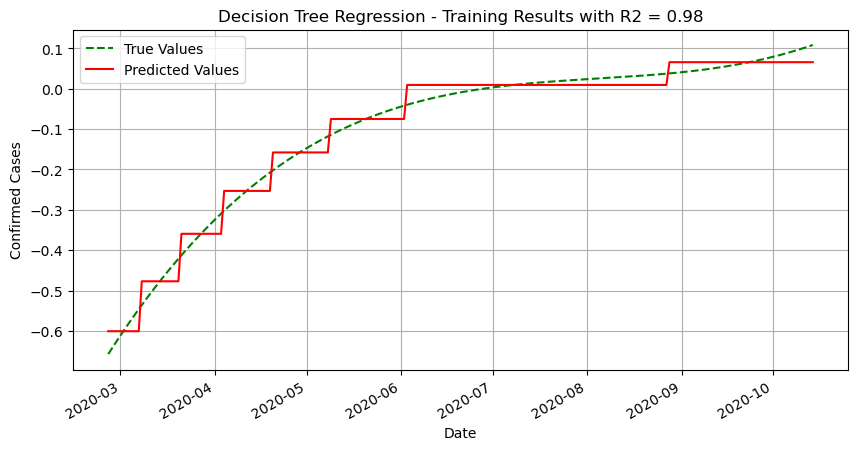

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_results['Date'], train_results['True'], label='True Values', linestyle='--', color='green')
plt.plot(train_results['Date'], train_results['Predicted'], label='Predicted Values', linestyle='-', color='red')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'Decision Tree Regression - Training Results with R2 = {train_r2:.2f}')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

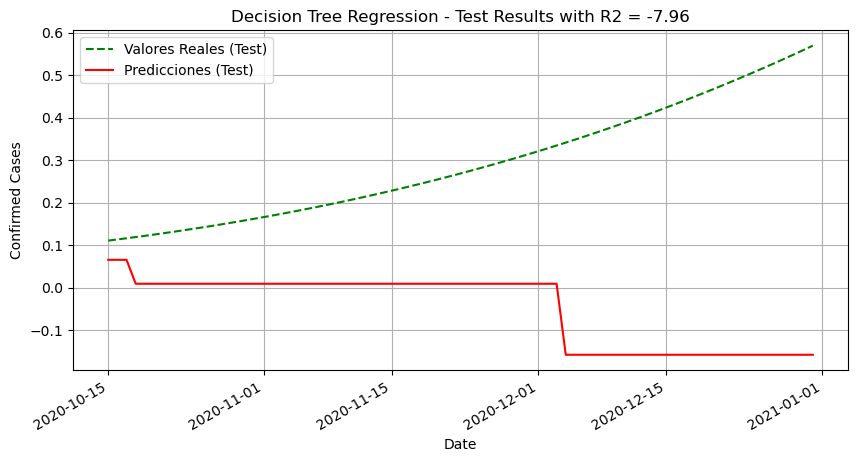

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(test_results['Date'], test_results['True'], label='Valores Reales (Test)', linestyle='--', color='green')
plt.plot(test_results['Date'], test_results['Predicted'], label='Predicciones (Test)', linestyle='-', color='red')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'Decision Tree Regression - Test Results with R2 = {test_r2:.2f}')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

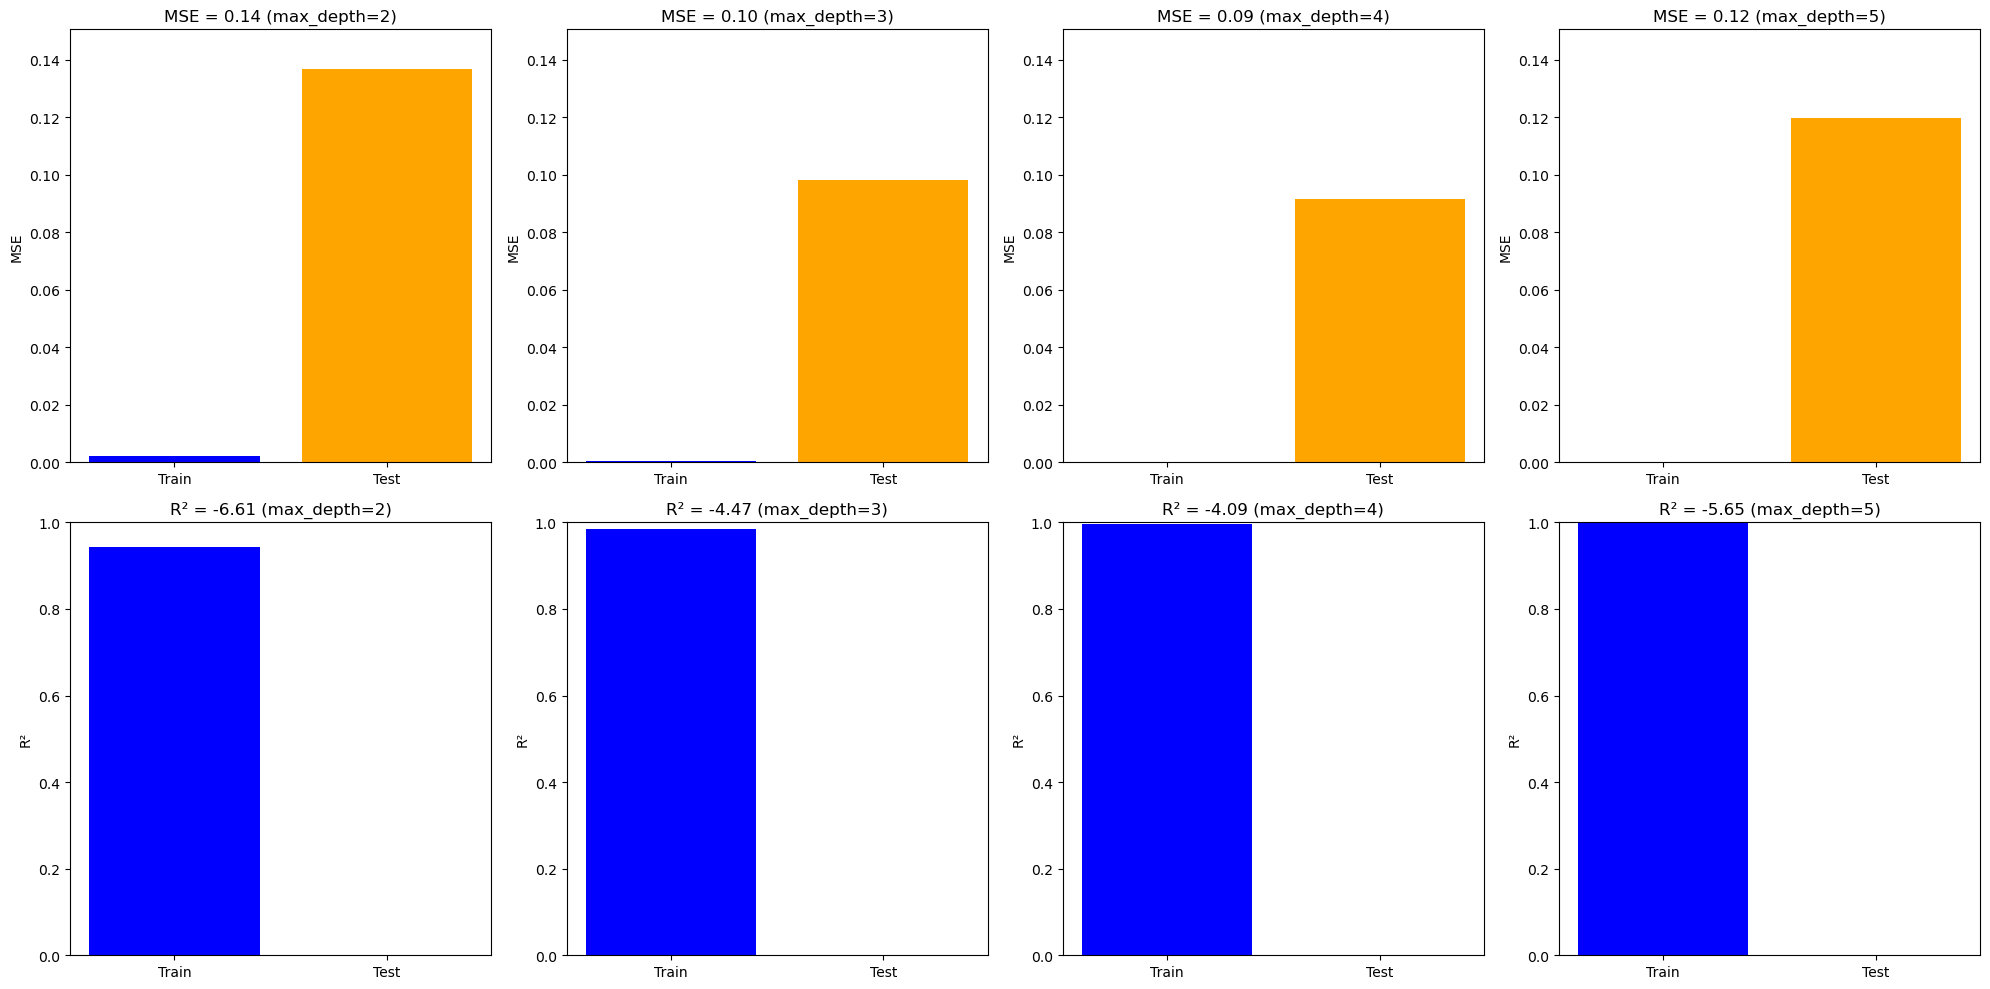

In [31]:
max_depths = [2, 3, 4, 5]

train_mse_list = []
test_mse_list = []
train_r2_list = []
test_r2_list = []

for max_depth in max_depths:
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

max_mse = max(train_mse_list + test_mse_list)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, max_depth in enumerate(max_depths):
    axs[0, i].bar(['Train', 'Test'], [train_mse_list[i], test_mse_list[i]], color=['blue', 'orange'])
    axs[0, i].set_title(f'MSE = {test_mse_list[i]:.2f} (max_depth={max_depth})')
    axs[0, i].set_ylabel('MSE')
    axs[0, i].set_ylim(0, max_mse * 1.1)

for i, max_depth in enumerate(max_depths):
    axs[1, i].bar(['Train', 'Test'], [train_r2_list[i], test_r2_list[i]], color=['blue', 'orange'])
    axs[1, i].set_title(f'R² = {test_r2_list[i]:.2f} (max_depth={max_depth})')
    axs[1, i].set_ylabel('R²')
    axs[1, i].set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

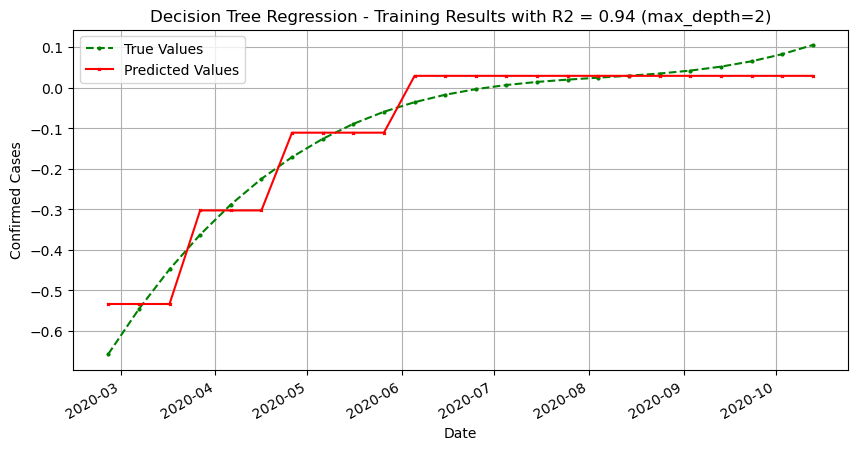

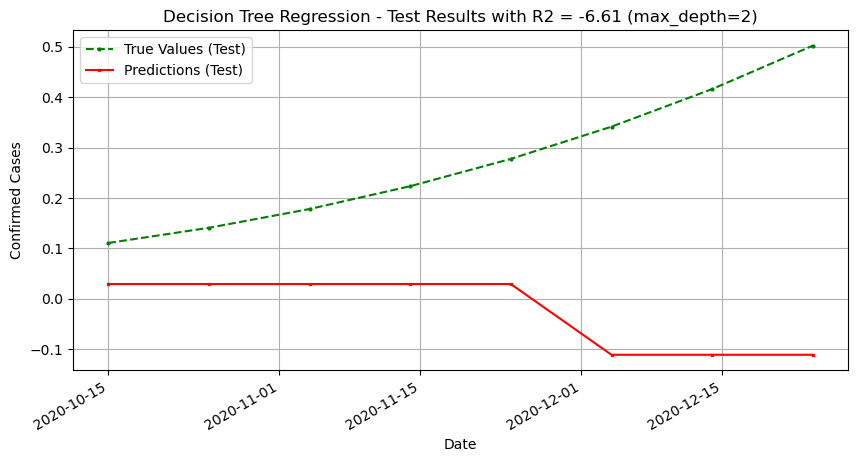

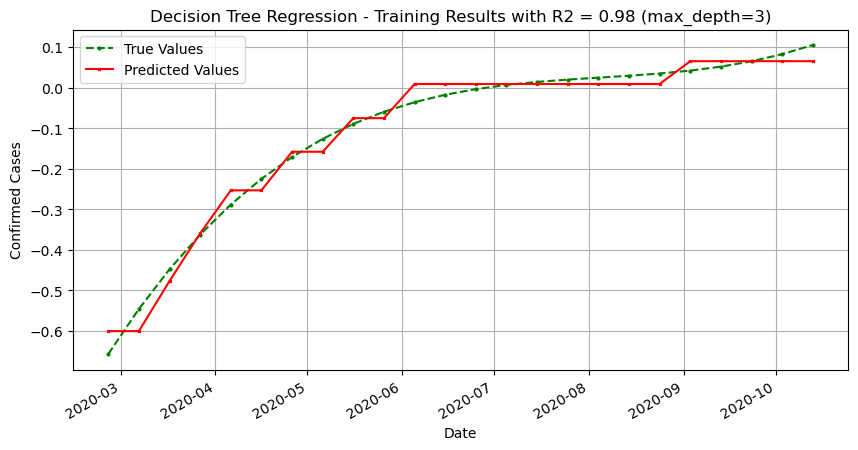

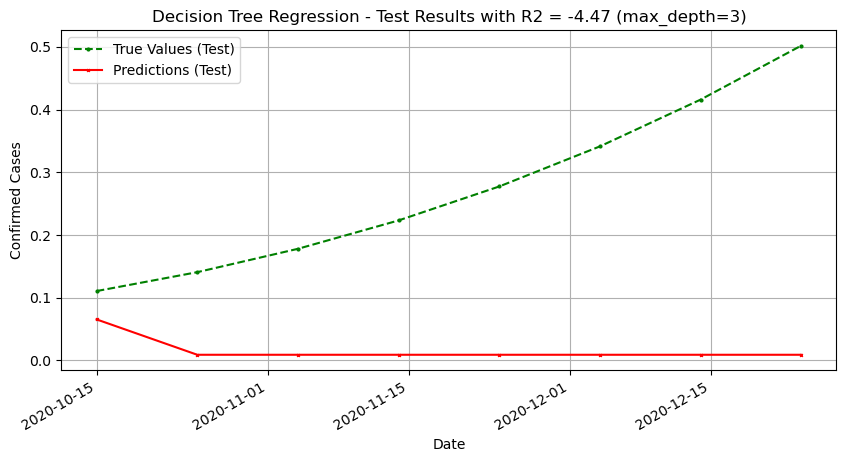

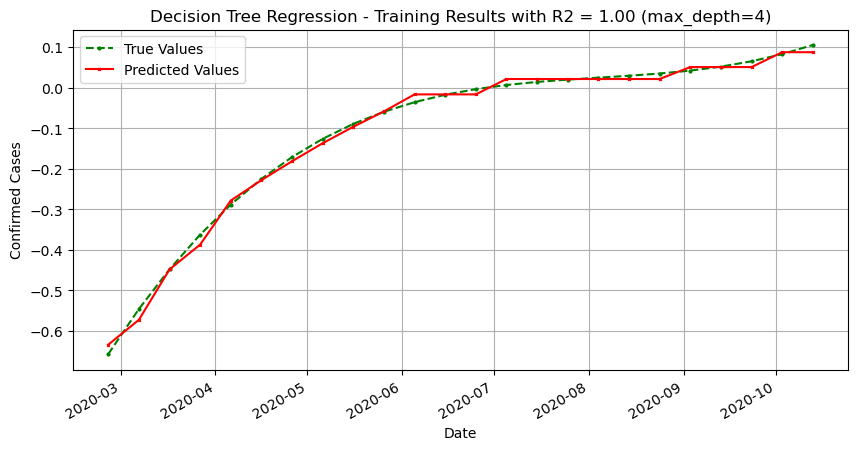

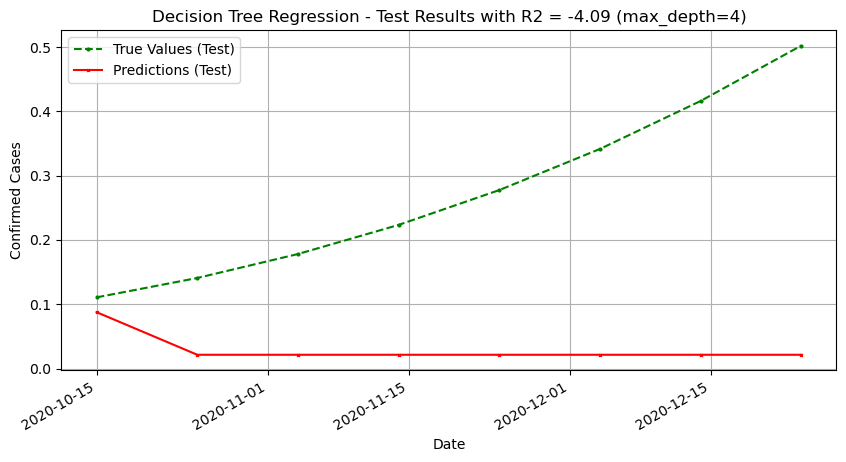

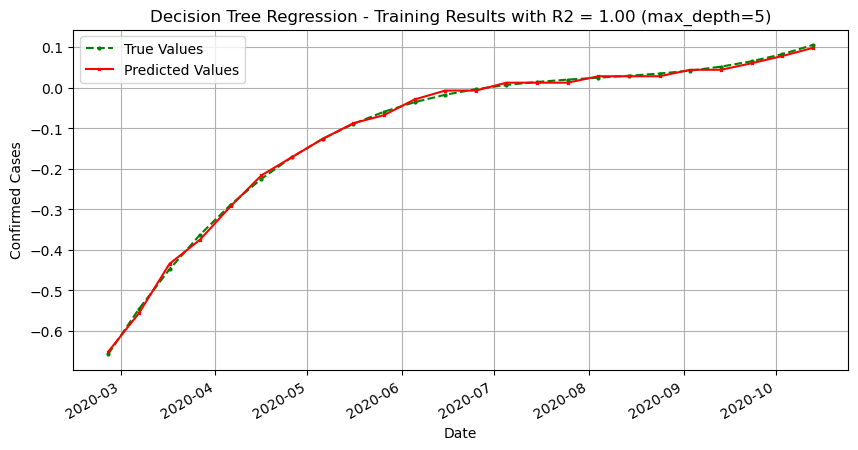

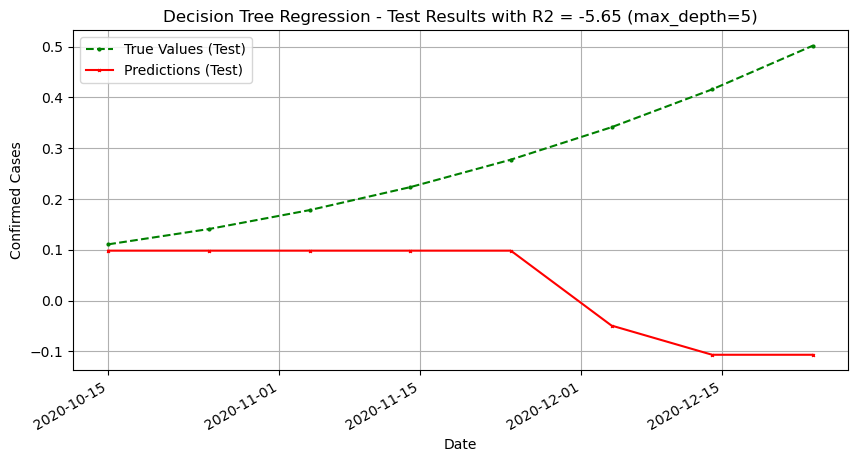

In [64]:
max_depths = [2, 3, 4, 5]

def plot_results(train_results, test_results, max_depth, train_r2, test_r2):
    plt.figure(figsize=(10, 5))
    
    plt.plot(train_results['Date'], train_results['True'], label='True Values', linestyle='--', color='green', marker='o', markersize=2)
    plt.plot(train_results['Date'], train_results['Predicted'], label='Predicted Values', linestyle='-', color='red', marker='x', markersize=2)
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.title(f'Decision Tree Regression - Training Results with R2 = {train_r2:.2f} (max_depth={max_depth})')
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.show()

    plt.figure(figsize=(10, 5))
    
    plt.plot(test_results['Date'], test_results['True'], label='True Values (Test)', linestyle='--', color='green', marker='o', markersize=2)
    plt.plot(test_results['Date'], test_results['Predicted'], label='Predictions (Test)', linestyle='-', color='red', marker='x', markersize=2)
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.title(f'Decision Tree Regression - Test Results with R2 = {test_r2:.2f} (max_depth={max_depth})')
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.show()

for max_depth in max_depths:
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    
    train_results = pd.DataFrame({
        'Date': X_train.index,
        'True': y_train,
        'Predicted': y_train_pred
    }).sort_values(by='Date')
    
    test_results = pd.DataFrame({
        'Date': X_test.index,
        'True': y_test,
        'Predicted': y_test_pred
    }).sort_values(by='Date')
    
    train_results_subset = train_results.iloc[::10, :]
    test_results_subset = test_results.iloc[::10, :]
    
    plot_results(train_results_subset, test_results_subset, max_depth, train_r2, test_r2)